In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil


# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Dense, DenseFeatures, concatenate)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# facets
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [2]:
# 데이터 불러오기. 
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

df_train_raw = pd.read_csv("/Users/jk/git/Study/Data/dataset/adult.data", header=None, names=COLUMNS, sep='\s*,\s*', engine='python', na_values="?")
df_test = pd.read_csv("/Users/jk/git/Study/Data/dataset/adult.test", skiprows=[0], header=None, names=COLUMNS, sep='\s*,\s*', engine='python')


In [3]:
jsonstr = df_train_raw.sample(2500).to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [4]:
fsg = FeatureStatisticsGenerator()
dataframes = [{'table': df_train_raw, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode('utf-8')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))



In [55]:
# 데이터 분리
# train : val : test = 5.3 : 1.3 : 3.3

df_train, df_val = np.split(df_train_raw, [int(0.8*len(df_train_raw))])
print(df_train.shape[0]/ (df_train.shape[0] + df_val.shape[0] + df_test.shape[0]))
print(df_val.shape[0]/ (df_train.shape[0] + df_val.shape[0] + df_test.shape[0]))
print(df_test.shape[0]/ (df_train.shape[0] + df_val.shape[0] + df_test.shape[0]))
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

test_label = df_train.iloc[:, -1]

test_feature, test_labels = df_train.iloc[:, :-1], df_train.iloc[:, -1]
print(test_feature.info())
print(test_labels)

0.5333114942058065
0.13334834773350804
0.33334015806068545
26048 6513 16281
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education       26048 non-null  object
 4   education_num   26048 non-null  int64 
 5   marital_status  26048 non-null  object
 6   occupation      26048 non-null  object
 7   relationship    26048 non-null  object
 8   race            26048 non-null  object
 9   gender          26048 non-null  object
 10  capital_gain    26048 non-null  int64 
 11  capital_loss    26048 non-null  int64 
 12  hours_per_week  26048 non-null  int64 
 13  native_country  26048 non-null  object
dtypes: int64(6), object(8)
memory usage: 2.8+ MB
None
0        <=50K
1        <=50K
2        <=50K
3        <=

In [56]:
# 데이터 전처리

def df_to_dataset(df, shuffle=True, batch_size=32):
    dataframe = df.copy()
    dataframe["income_bracket"] = dataframe["income_bracket"].apply(lambda x: ">50K" in x).astype(int)
    
    features, labels = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]

    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features))
    ds = ds.batch(batch_size)
    return ds

In [57]:
# 결측치(?표시로 되어있음) 제거 
# 결측치의 수(2399)가 10% 미만(7.36%)이므로 삭제. ? 를 결측치로 인정하지 않는 이유. ?를 삭제하게되면 
# workclass 컬럼의 중요한 요소인 "Never-worked" 항목이 사라진다. 그래서 그냥 ?를 안고 가기로함.

# 카테고리 컬럼
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'])

gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])

education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

# hashing 컬럼 - 카테고리 컬럼 중 갯수가 많아 

occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

age = tf.feature_column.numeric_column("age")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

eo_crossed = tf.feature_column.crossed_column(
        ["education", "occupation"], hash_bucket_size=1000)

no_crossed = tf.feature_column.crossed_column(
        ["native_country", "occupation"], hash_bucket_size=1000)


wide_columns = [
    # 카테고리 컬럼
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(gender),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.indicator_column(marital_status),
    
    # crossed_columns
    tf.feature_column.indicator_column(eo_crossed),
    tf.feature_column.indicator_column(no_crossed),
    
    # bucket화된 컬럼
    age_buckets


]

deep_columns = [    
    # 임베딩 데이터
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
    
    # 연속성 데이터
    age,
    education_num,
    capital_gain,
    capital_loss,
    hours_per_week,
]

In [58]:
# 특성 층 만들기?
INT_COLUMNS = {"age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"}
String_COLUMNS = {"workclass", "education", "marital_status", "occupation", "relationship", "race", "gender", "native_country"}

# int
inputs_int = {colname : Input(name=colname, shape=(), dtype=tf.int64) for colname in INT_COLUMNS}

# object
inputs_string = {colname : Input(name=colname, shape=(), dtype=tf.string) for colname in String_COLUMNS}

inputs = {**inputs_int, **inputs_string}

y_train = df_train["income_bracket"].apply(lambda x: ">50K" in x).astype(int)
y_test = df_test["income_bracket"].apply(lambda x: ">50K" in x).astype(int)

In [59]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_model(dnn_hidden_units):
    # Create the deep part of model
    deep = DenseFeatures(deep_columns, name="deep_inputs")(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation="relu")(deep)
    
    # Create the wide part of model
    wide = DenseFeatures(wide_columns, name="wide_inputs")(inputs)
    
    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide], name='combined')
    
    # Map the combined outputs into a single prediction value
    output = Dense(units=1, activation="sigmoid", name="prediction")(combined)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)
    
    # compile the keras model
    model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])
    
    return model

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       26048 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education       26048 non-null  object
 4   education_num   26048 non-null  int64 
 5   marital_status  26048 non-null  object
 6   occupation      26048 non-null  object
 7   relationship    26048 non-null  object
 8   race            26048 non-null  object
 9   gender          26048 non-null  object
 10  capital_gain    26048 non-null  int64 
 11  capital_loss    26048 non-null  int64 
 12  hours_per_week  26048 non-null  int64 
 13  native_country  26048 non-null  object
 14  income_bracket  26048 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.0+ MB


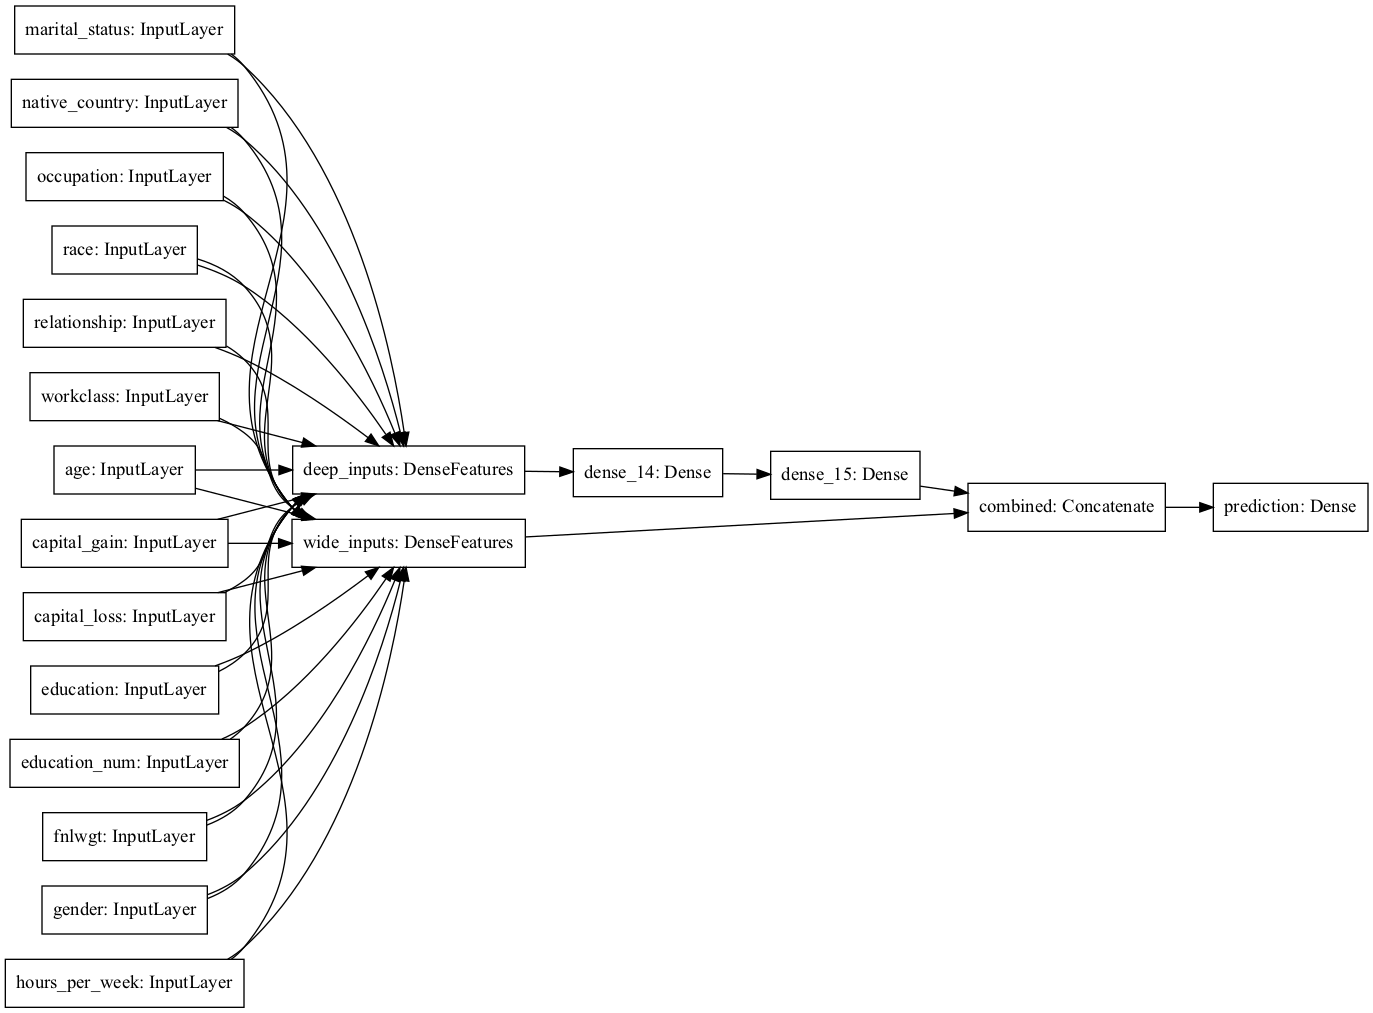

In [69]:
HIDDEN_UNITS = [10, 10] 
model = build_model(dnn_hidden_units=HIDDEN_UNITS)

tf.keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [62]:
BATCH_SIZE = 64
train_ds = df_to_dataset(df_train, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(df_val, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(df_test, shuffle=False, batch_size=BATCH_SIZE)


In [63]:
for feature_batch, labal_batch in train_ds.take(1):
    print(feature_batch)
    print()
    print(labal_batch)

{'age': <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([53, 38, 29, 52, 29, 67, 20, 48, 50, 28, 41, 25, 21, 81, 37, 62, 56,
       55, 46, 22, 17, 26, 21, 45, 64, 47, 37, 39, 50, 29, 49, 42, 31, 47,
       20, 33, 20, 57, 30, 35, 44, 49, 47, 23, 29, 37, 21, 37, 45, 83, 38,
       58, 50, 39, 40, 38, 29, 44, 35, 52, 58, 34, 35, 45])>, 'workclass': <tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Private', b'Private', b'Private', b'Federal-gov', b'Private',
       b'?', b'?', b'Private', b'Private', b'Private', b'Private',
       b'Private', b'Private', b'Self-emp-inc', b'Private', b'Private',
       b'Self-emp-not-inc', b'Private', b'Private', b'Federal-gov',
       b'Private', b'Private', b'Private', b'Private', b'State-gov',
       b'Private', b'Private', b'Private', b'Private', b'Private',
       b'Private', b'Private', b'State-gov', b'Federal-gov', b'Private',
       b'Private', b'Private', b'Self-emp-not-inc', b'?', b'State-gov',
       b'Private', b'Self-emp-not-inc', b'

In [64]:
NUM_EVALS = 2

OUTDIR = "./adult_train" 
shutil.rmtree(path=OUTDIR, ignore_errors=True)

history = model.fit(x=train_ds,
                    steps_per_epoch=1,
                    epochs=NUM_EVALS,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[TensorBoard(OUTDIR)])

Epoch 1/2


/Users/jk/setup/anaconda3/envs/python_pro2net/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1/1 [==============================] - 2s 2s/step - loss: 13.4812 - accuracy: 0.6875 - val_loss: 15.3903 - val_accuracy: 0.7543
Epoch 2/2
1/1 [==============================] - 0s 278ms/step - loss: 13.3006 - accuracy: 0.7812 - val_loss: 14.5460 - val_accuracy: 0.7543


In [65]:
loss, acc = model.evaluate(test_ds)

255/255 [==============================] - 0s 2ms/step - loss: 15.1762 - accuracy: 0.7638
